In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import os
import sys
import pandas as pd
import time
sys.path.append('../..')

from src.model.two_steps.model import KNN, WeatherGenerator
from src.validation.validation import loss
import pickle
from experiments.real.config import * 
from tqdm import tqdm
from collections import Counter
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
from src.model.true import check_duration
from joblib import Parallel, delayed
def parallel_observed(data, date):
    try:
        return check_duration(
            data=data, date_start=date,
            tasks_conditions=tasks_conditions, project_schedule=project_schedule)
    except Exception as e:
        print(date, e)
        return 0

In [3]:
results_dir = os.path.join('..', '..', 'data', 'real', 'results_4years')
src_ids = [
    dir_name for dir_name in sorted(os.listdir(results_dir), reverse=True)
    if dir_name.isdigit() and os.path.exists(os.path.join(results_dir, dir_name, 'metrics_test.pickle'))
    ]
len(src_ids )

65

In [4]:
months = [str(month).zfill(2) for month in range(1, 13)]
years = [str(year) for year in range(1985, 2021)]
dates = [f"{year}-{month}-01" for year in years for month in months]

In [29]:
date_start = datetime.date(2017, 1, 1)
date_end = datetime.date(2017, 12, 31)
dates = sorted(set([(date_start+datetime.timedelta(days=x)).isoformat()[5:] for x in range(0, (date_end-date_start).days+1, 7)]))
years = [str(year) for year in range(1985, 2021)]
dates = [f"{year}-{date_part}" for year in years for date_part in dates]

In [ ]:
from tqdm  import tqdm
results = []
results_before = []

src_durations = {}
for src_id in tqdm(src_ids):
    data = pd.read_csv(os.path.join('..', '..', 'data', 'cleaned', f"{src_id}.csv")).fillna(nan).replace([None], [nan])
    durations = (
        Parallel(n_jobs=-1, prefer="processes")
        (delayed(parallel_observed)(data=data, date=date) 
        for date in dates
        ))
    durations = {date: duration for date, duration in zip(dates, durations) if duration > 0}
    src_durations[src_id] = durations

In [30]:
len(dates)

1908

In [31]:
from tqdm  import tqdm
results = []
results_before = []

src_durations = {}
for src_id in tqdm(src_ids):
    data = pd.read_csv(os.path.join('..', '..', 'data', 'cleaned', f"{src_id}.csv")).fillna(nan).replace([None], [nan])
    durations = (
        Parallel(n_jobs=-1, prefer="processes")
        (delayed(parallel_observed)(data=data, date=date) 
        for date in dates
        ))
    durations = {date: duration for date, duration in zip(dates, durations) if duration > 0}
    src_durations[src_id] = durations

  3%|▎         | 2/65 [06:36<3:28:08, 198.24s/it]


KeyboardInterrupt: 

In [ ]:
with open(os.path.join('src_durations.pickle'), 'wb') as file:
    pickle.dump(src_durations, file, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'src_durations' is not defined

In [5]:
with open(os.path.join("src_durations.pickle"), 'rb') as file:
    src_durations = pickle.load(file)

EOFError: Ran out of input

In [9]:
#results = pd.DataFrame([{'src_id': src_id, 'date': date, 'duration': duration} for src_id, durations in src_durations.items() for date, duration in durations.items()])
#for month in months:
#    print(month)
#    fig = (
#        results
#        .loc[lambda df: df['date'].apply(lambda v: v[5:7] == month)]
#        .pipe(lambda df: (
#            px.box(df, x='date', y='duration')
#        ))
#    )
#    fig.update_traces(boxpoints=False) 
#    display(fig)

In [33]:
results = []
results_before = []
for src_id in src_ids:
    if src_id not in src_durations:
        continue
    durations = src_durations[src_id]
    quantiles = {}
    quantiles_before= {}
    for month in months:
        month_durations = {_date: duration for _date, duration in durations.items() if _date[5:7] == month}
        n = len(month_durations)
        for year in years:
            date = f"{year}-{month}-01"
            if date not in durations:
                continue
        
            quantiles[date] = int(stats.percentileofscore(list(month_durations.values()), durations[date], kind='strict'))
            if date >= '2010':
                before_duration = [duration for _date, duration in month_durations.items() if _date < date]
                if before_duration:
                    quantiles_before[date] = int(stats.percentileofscore(before_duration, durations[date], kind='strict'))

    quantiles = {date: quantiles[date] for date in sorted(quantiles)}
    quantiles_before = {date: quantiles_before[date] for date in sorted(quantiles_before)}

    results.extend([{'date': date, 'quantile': quantile, 'src_id': src_id} for date, quantile in quantiles.items()])
    results_before.extend([{'date': date, 'quantile': quantile, 'src_id': src_id} for date, quantile in quantiles_before.items()])

Text(0, 0.5, 'Quantil Real')

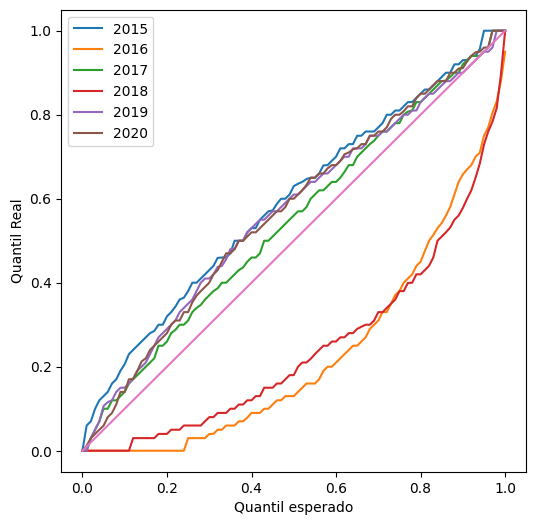

In [67]:

plt.figure(figsize=(6,6))
for i, year in enumerate(['2015', '2016', '2017', '2018', '2019', '2020']):
    quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in [year])]['quantile'].tolist()
    df_quantil = (
        pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
        .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
    plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)


plt.plot([0, 1], [0,1])

plt.legend()
plt.xlabel('Quantil esperado')
plt.ylabel('Quantil Real')

In [78]:

fig = go.Figure()
colors = ['#1F78B4', '#FE7F0E', '#2BA02D', '#C03D3E', '#BA55D3']

for i, year in enumerate(['2016', '2017', '2018', '2019', '2020']):
    color = colors[i]
    quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in [year])]['quantile'].tolist()
    df_quantil = (
        pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
        .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
    fig_ = go.Scatter(x=df_quantil['quantil_esperado'].tolist(), y=df_quantil['quantil_real'].tolist(), name=year)
    fig.add_trace(fig_)

fig_ = go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Linha identidade",
        line=dict(color='rgba(0,0,0,0.6)', dash='dash')
    )
fig.add_trace(fig_)

fig.update_xaxes(range=[0, 1],  title="Quantil esperado")
fig.update_yaxes(range=[0, 1],  title="Quantil real")

fig.update_layout(
    template = "simple_white",
    width=900, height=800,
    margin=dict(t=50))

fig.write_image('real_dataset_quantis.pdf')

Text(0, 0.5, 'Quantil Real')

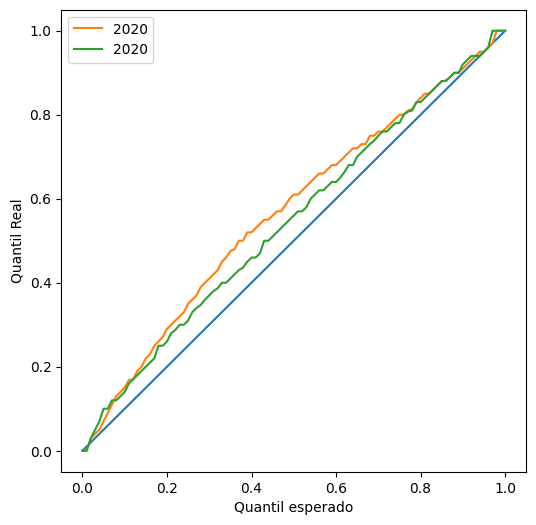

In [35]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2019', '2020'])]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)



quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2017'])]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)


plt.legend()
plt.xlabel('Quantil esperado')
plt.ylabel('Quantil Real')

Text(0, 0.5, 'Quantil Real')

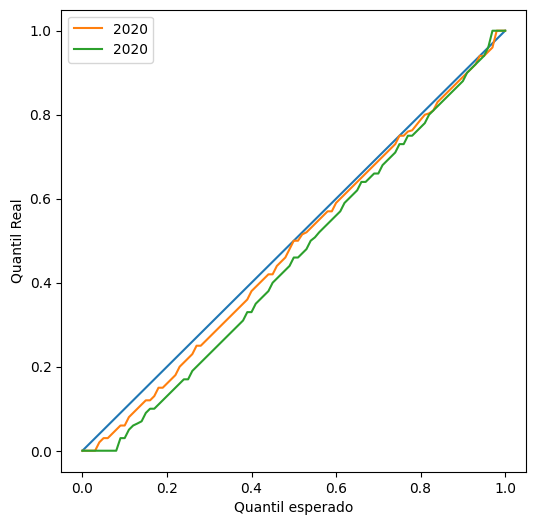

In [36]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2017', '2018', '2019', '2020'])]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2013', '2014', '2015', '2016'])]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)


plt.legend()
plt.xlabel('Quantil esperado')
plt.ylabel('Quantil Real')

In [47]:
import plotly.graph_objects as go

In [60]:
fig = (
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(
        quantile = ('quantile', np.mean),
        quantile_std = ('quantile', np.std),
        n = ('quantile', 'count'),
        )
    .reset_index()
    .loc[lambda df: df['year'] >= '2015']
    .assign(
        quantile_error = lambda df: df['quantile_std']/np.sqrt(df['n']),
        year = lambda df: df['year'].astype(int) + 0.05 * np.random.randn(len(df)))
    .pipe(lambda df: (
        go.Figure(go.Scatter(
            x=df['year'], y=df['quantile'], mode='markers',
            error_y=dict(
                type='data', # tipo de barra de erro 
                array=df[f'quantile_error'], # valor do erro em y para cada ponto (acima)
                arrayminus=df[f'quantile_error'], # valor do erro em y para cada ponto (abaixo)
                visible=True, color='Blue')))
    ))
)
fig

In [56]:
fig = (
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(
        quantile = ('quantile', np.mean),
        quantile_std = ('quantile', np.std),
        n = ('quantile', 'count'),
        )
    .reset_index()
    .assign(quantile_error = lambda df: df['quantile_std']/np.sqrt(df['n']))
    .loc[lambda df: df['year'] >= '2015']
    .pipe(lambda df: (
        px.strip(df, x='year', y='quantile')
    ))
)
print(fig.data)

(Box({
    'alignmentgroup': 'True',
    'boxpoints': 'all',
    'fillcolor': 'rgba(255,255,255,0)',
    'hoveron': 'points',
    'hovertemplate': 'year=%{x}<br>quantile=%{y}<extra></extra>',
    'legendgroup': '',
    'line': {'color': 'rgba(255,255,255,0)'},
    'marker': {'color': '#636efa'},
    'name': '',
    'offsetgroup': '',
    'orientation': 'v',
    'pointpos': 0,
    'showlegend': False,
    'x': array(['2015', '2015', '2015', ..., '2020', '2020', '2020'], dtype=object),
    'x0': ' ',
    'xaxis': 'x',
    'y': array([58.14285714, 73.25      , 69.66666667, ...,  4.58333333, 37.33333333,
                42.25      ]),
    'y0': ' ',
    'yaxis': 'y'
}),)


In [ ]:

go.Scatter(
            x=_results[f'two_steps_{loss}_mean'],
            y=_results[f'weather_pert_{loss}_mean'],
            mode='markers',
            name=label,
            error_y=dict(
                type='data', # tipo de barra de erro 
                array=_results[f'weather_pert_{loss}_mean_error'], # valor do erro em y para cada ponto (acima)
                arrayminus=_results[f'weather_pert_{loss}_mean_error'], # valor do erro em y para cada ponto (abaixo)
                visible=True, color=config['cor_erro']),
            error_x=dict(
                type='data', # tipo de barra de erro 
                array=_results[f'two_steps_{loss}_mean_error'], # valor do erro em x para cada ponto (direita)
                arrayminus=_results[f'two_steps_{loss}_mean_error'], # valor do erro em x para cada ponto (esquerda)
                visible=True, color=config['cor_erro']),
            marker=dict(
                color=config['cor_ponto'], 
                size=5, line=dict(width=1, color='DarkSlateGrey')
            ),
        )


            error_y=dict(
                type='data', # tipo de barra de erro 
                array=_results[f'weather_pert_{loss}_mean_error'], # valor do erro em y para cada ponto (acima)
                arrayminus=_results[f'weather_pert_{loss}_mean_error'], # valor do erro em y para cada ponto (abaixo)
                visible=True, color=config['cor_erro']),

In [41]:
(
    pd.DataFrame(results)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.strip(df, x='year', y='quantile')
    ))
)

In [14]:
(
    pd.DataFrame(results_before)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.box(df, x='date', y='quantile')
    ))
)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


for year in ['2016', '2017', '2018', '2019', '2020']:
    quantis = (pd.DataFrame(results)).loc[lambda df: df['date'].apply(lambda v: v[:4] in [year])]['quantile'].tolist()
    df_quantil = (
        pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
        .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
    plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)
plt.legend()

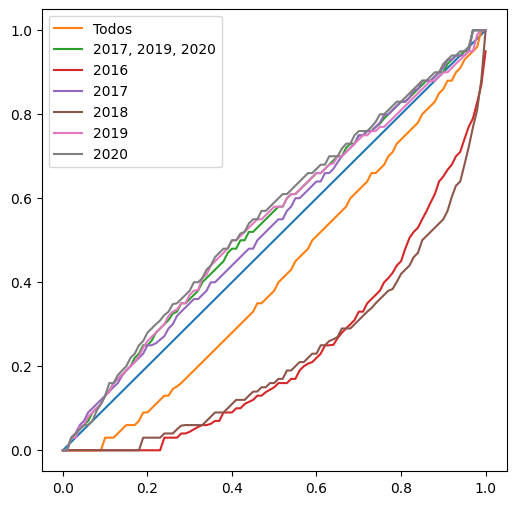

In [31]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label='Todos')


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2017', '2019', '2020'])]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label='2017, 2019, 2020')

for year in ['2016', '2017', '2018', '2019', '2020']:
    quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in [year])]['quantile'].tolist()
    df_quantil = (
        pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
        .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
    plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist(), label=year)
plt.legend()

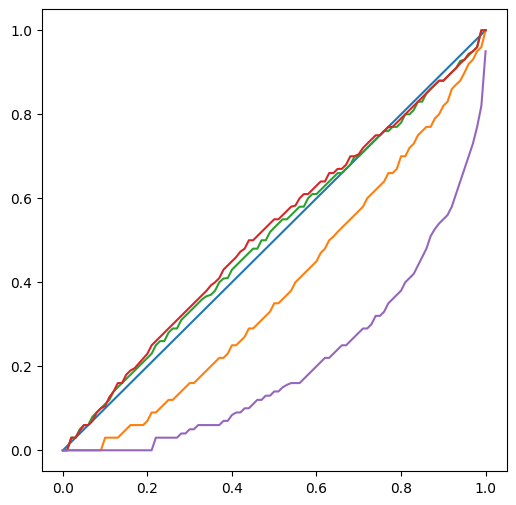

In [24]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')&(df['src_id'].isin(model_src_id['two_steps']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())

quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2017', '2019', '2020'])&(df['src_id'].isin(model_src_id['two_steps']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2019', '2020'])&(df['src_id'].isin(model_src_id['two_steps']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())



quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2016', '2018'])&(df['src_id'].isin(model_src_id['two_steps']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())

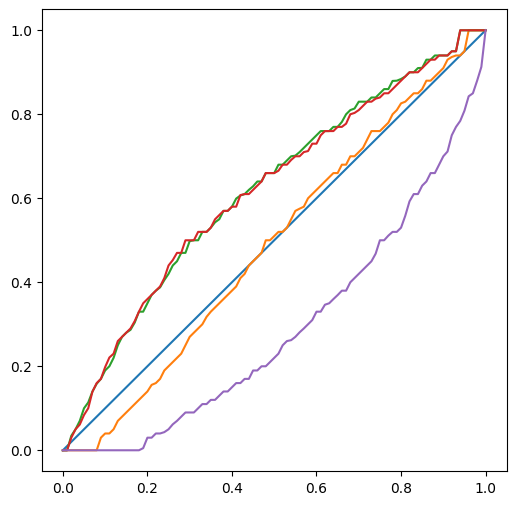

In [23]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0,1])


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')&(df['src_id'].isin(model_src_id['weather_pert']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())

quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2017', '2019', '2020'])&(df['src_id'].isin(model_src_id['weather_pert']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())


quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2019', '2020'])&(df['src_id'].isin(model_src_id['weather_pert']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())



quantis = (pd.DataFrame(results_before)).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2016', '2018'])&(df['src_id'].isin(model_src_id['weather_pert']))]['quantile'].tolist()
df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())

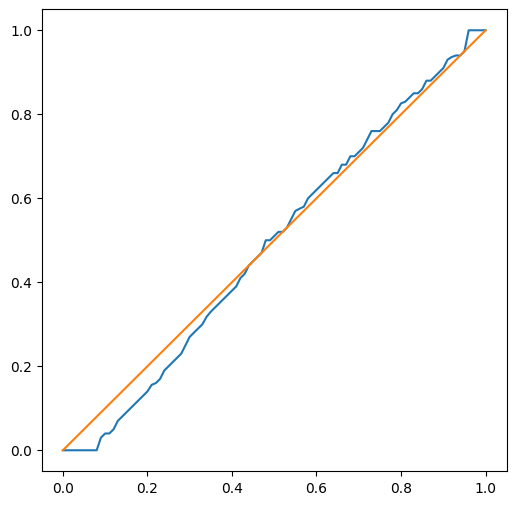

In [18]:
quantis = (
    pd.DataFrame(results_before)
    ).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')&(df['src_id'].isin(model_src_id['weather_pert']))]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)
plt.figure(figsize=(6,6))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])

In [ ]:
quantis = (
    pd.DataFrame(results)
    ).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)
plt.figure(figsize=(6,6))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])

In [ ]:
(
    pd.DataFrame(results)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.box(df, x='year', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.box(df, x='date', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.strip(df, x='year', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2016']
    .pipe(lambda df: df['quantile'] < 20).mean()
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
quantis = (
    pd.DataFrame(results_before)
    ).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)
plt.figure(figsize=(6,6))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])

In [ ]:
quantis = (
    pd.DataFrame(results)
    ).loc[lambda df: df['date'].apply(lambda v: v[:4] >= '2016')]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)
plt.figure(figsize=(6,6))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])

In [ ]:
df_quantil.head(60)

In [ ]:
quantis = (
    pd.DataFrame(results_before)
    ).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2019', '2020'])]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)
plt.figure(figsize=(4,4))
plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])

In [ ]:
quantis = pd.DataFrame(results_before).loc[lambda df: df['date'].apply(lambda v: v[:4] in ['2019', '2020'])]['quantile'].tolist()

df_quantil = (
    pd.DataFrame({'quantil_esperado': np.arange(0, 1.01, 0.01)})
    .assign(quantil_real = lambda df: df['quantil_esperado'].apply(lambda v: np.quantile(quantis, v))/100)
)

plt.plot(df_quantil['quantil_esperado'].tolist(), df_quantil['quantil_real'].tolist())
plt.plot([0, 1], [0,1])
plt.show()

In [ ]:
(
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.box(df, x='year', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results_before)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.box(df, x='date', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results_before)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.strip(df, x='date', y='quantile')
    ))
)

In [ ]:
results = []
results_before = []
for src_id in src_ids:
    durations = src_durations[src_id]
    quantiles = {}
    quantiles_before= {}
    for month in months:
        month_durations = {_date: duration for _date, duration in durations.items() if _date[5:7] == month}
        month_durations = {date: month_durations[date] for date in sorted(month_durations, key=lambda date: month_durations[date])}
        #month_durations = sorted(month_durations, key=lambda date: month_durations[date])
        n = len(month_durations)
        for year in years:
            date = f"{year}-{month}-01"
            if date not in durations:
                continue

            quantiles[date] = next(i for i, _date in enumerate(sorted(month_durations, key=lambda date: month_durations[date])) if _date == date)
            before_duration = [duration for _date, duration in month_durations.items() if _date < '2016' ]
            quantiles_before[date] = next((i for i, duration in enumerate([duration for _date, duration in month_durations.items() if _date < '2016' ]) if duration >= month_durations[date]), len(before_duration))

            
            
        
    quantiles = {date: quantiles[date] for date in sorted(quantiles)}
    quantiles_before = {date: quantiles_before[date] for date in sorted(quantiles_before)}

    results.extend([{'date': date, 'quantile': quantile, 'src_id': src_id} for date, quantile in quantiles.items()])
    results_before.extend([{'date': date, 'quantile': quantile, 'src_id': src_id} for date, quantile in quantiles_before.items()])

In [ ]:
(
    pd.DataFrame(results)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.box(df, x='year', y='quantile')
    ))
)

In [ ]:
(
    pd.DataFrame(results)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.box(df, x='date', y='quantile')
    ))
)

In [ ]:
fig = (
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.strip(df, x='year', y='quantile')
    ))
)
#fig.update_traces(boxpoints=False) 
display(fig)

In [ ]:
fig = (
    pd.DataFrame(results_before)
    .assign(year = lambda df: df['date'].apply(lambda v: v[:4]))
    .groupby(['year', 'src_id'])
    .agg(quantile = ('quantile', np.median))
    .reset_index()
    .loc[lambda df: df['year'] >= '2011']
    .pipe(lambda df: (
        px.box(df, x='year', y='quantile')
    ))
)
#fig.update_traces(boxpoints=False) 
display(fig)

In [ ]:
(
    pd.DataFrame(results_before)
    .loc[lambda df: df['date'] >= '2016']
    .pipe(lambda df: (
        px.box(df, x='date', y='quantile')
    ))
)

In [ ]:
project_schedule = {
    'earthworks_1': 15,
    'concrete_1': 15,
    'steelworks_1': 15,
    'formworks_1': 15,
    'pavements_1': 10,
    'outdoor_1': 10,
    'earthworks_2': 15,
    'concrete_2': 15,
    'steelworks_2': 15,
    'formworks_2': 15,
    'pavements_2': 10,
    'outdoor_2': 10,
}

In [ ]:
date = '2017-06-01'
display(print_density(durations=[duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]], observed=observed[date], models={'weather_pert': weather_pert[date], 'two_steps': two_steps[date]}))
{_date: duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]}

In [ ]:
date = '2018-06-01'
display(print_density(durations=[duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]], observed=observed[date], models={'weather_pert': weather_pert[date], 'two_steps': two_steps[date]}))
{_date: duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]}

In [ ]:

import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py

def print_density(durations,  observed, models):



    fig = go.Figure()
    point_no_sig = 'rgb(96,96,96)'
    point_sig = 'rgb(0,0,0)'
    identity = 'red'

    names = list(models.keys())

    fig = make_subplots(rows=3, cols=1, row_heights=[0.6, 0.3, 0.1], shared_xaxes=True)

    min_durations = min(durations)
    max_durations = max(durations)
    counter = dict(Counter(durations))
    print(sorted(durations))
    x = [x for x in list(range(min_durations, max_durations + 1)) if counter.get(x, 0)]
    y = [counter.get(d, 0) for d in x]
    text=[str(i) for i in range(len(x))]
    fig.add_trace(go.Scatter(
        x=x, y=y, text=text,
        line=dict(color='gray', width=2),
        name='history', mode='markers+text'
        ), row=2, col=1)
        

    print(observed)
    fig_ = go.Box(
        x=[observed], 
        marker_symbol='line-ns-open', 
        marker_color='rgba(255,255,255,0)',
        boxpoints='all',
        jitter=0,
        fillcolor='black',
        line_color='black',
        #hoveron='points',
        name='observed'
        )
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=3, col=1)

    color = ['red', 'blue', 'gray', 'yellow', 'orange', 'black']
    for i , (model, estimate) in enumerate(models.items()):
        min_estimate = min(estimate)
        max_estimate = max(estimate)
        counter = dict(Counter(estimate))
        x = list(range(min_estimate, max_estimate + 1))
        y = [counter.get(d, 0) for d in x]
        fig.add_trace(go.Scatter(
            x=x, y=y,
            line=dict(color=color[i], width=2),
            name=model
            ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=[np.median(estimate)], y=[0],
            line=dict(color=color[i], width=2),
            name=model, mode='markers'
            ), row=1, col=1)
        

    fig.update_layout(
        # xaxis_title='Tempo de execução (dias)',
        # yaxis_title='$Z$',
        template = "simple_white",
        width=800, height=600
        )
    fig.update_xaxes(title_text='Tempo de execução (dias)', row=2, col=1)
    fig.update_yaxes(title_text='$Z$', row=1, col=1)
    return fig

In [ ]:
from src.model.true import check_duration
from joblib import Parallel, delayed
def parallel_observed(data, date):
    try:
        return check_duration(
            data=data, date_start=date,
            tasks_conditions=tasks_conditions, project_schedule=project_schedule)
    except Exception as e:
        print(date, e)
        return 0
data = pd.read_csv(os.path.join('..', '..', 'data', 'cleaned', f"{src_id}.csv")).fillna(nan).replace([None], [nan])

dates = [f"{year}-{str(month).zfill(2)}-01" for year in range(1985, 2021) for month in range(1, 13)]
durations = (
    Parallel(n_jobs=-1, prefer="processes")
    (delayed(parallel_observed)(
        data=data, date=date)
    for date in dates
    ))
durations = {date: duration for date, duration in zip(dates, durations) if duration > 0}

In [ ]:
results_dir = os.path.join('..', '..', 'data', 'results')

In [ ]:
src_ids = [
    dir_name for dir_name in sorted(os.listdir(results_dir), reverse=True)
    if dir_name.isdigit() and os.path.exists(os.path.join(results_dir, dir_name, 'metrics_test.pickle'))
    ]
len(src_ids )

In [ ]:
from scipy.stats import mannwhitneyu
alpha = 0.05

In [ ]:
src_id = 987

In [ ]:
with open(os.path.join(results_dir, str(src_id), "weather_pert_hpt_best.pickle"), 'rb') as file:
    weather_pert_hpt_best = pickle.load(file)
print(weather_pert_hpt_best)

In [ ]:
with open(os.path.join(results_dir, str(src_id), "observed.pickle"), 'rb') as file:
    observed = pickle.load(file)
print(observed)

In [ ]:
with open(os.path.join(results_dir, str(src_id), "weather_pert_estimate.pickle"), 'rb') as file:
    weather_pert = pickle.load(file)
print(weather_pert)

In [ ]:
with open(os.path.join(results_dir, str(src_id), "two_steps_estimate.pickle"), 'rb') as file:
    two_steps = pickle.load(file)
print(two_steps)

In [ ]:
with open(os.path.join(results_dir, str(src_id), "metrics_test.pickle"), 'rb') as file:
    metrics = pickle.load(file)

In [ ]:
observed = {k: v for k, v in observed.items() if k[:4] in ['2016', '2017', '2018', '2019', '2020']}

In [ ]:
#src_id = 987

In [ ]:
from src.model.weather_pert.model import WeatherPert

date = '2016-05-01'
_data = data[data['date'] < date]

models = {}
model = WeatherPert(alpha=0.85, smoothing=3, mc=True)
model.fit(data=_data, tasks_conditions=tasks_conditions)
models['alpha: 0.85, mc=True'] = model.predict(date_start='2016-05-01', project_schedule=project_schedule, B=10_000)


model = WeatherPert(alpha=0.85, smoothing=3, mc=False)
model.fit(data=_data, tasks_conditions=tasks_conditions)
models['alpha: 0.85, mc=False'] = model.predict(date_start='2016-05-01', project_schedule=project_schedule, B=10_000)


model = WeatherPert(alpha=1, smoothing=3, mc=True)
model.fit(data=_data, tasks_conditions=tasks_conditions)
models['alpha: 1, mc=True'] = model.predict(date_start='2016-05-01', project_schedule=project_schedule, B=10_000)


model = WeatherPert(alpha=1, smoothing=3, mc=False)
model.fit(data=_data, tasks_conditions=tasks_conditions)
models['alpha: 1, mc=False'] = model.predict(date_start='2016-05-01', project_schedule=project_schedule, B=10_000)



display(print_density(durations=[duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]], observed=215, models=models))

In [ ]:
weather_pert_hpt_best['right-tail']

In [ ]:
display(print_density(durations=durations, models={'weather_pert': weather_pert[date], 'two_steps': two_steps[date]}))

In [ ]:
display(pd.DataFrame(metrics).drop(columns='date').groupby('model').agg('mean'))
print(weather_pert_hpt_best['right-tail'])
for date, value in observed.items():
    print(date)
    display(pd.DataFrame([m for m in metrics if m['date'] == date])[['model', 'right-tail', 'density', 'pinball', 'centered', 'two-tailed', 'left-tail', 'mse', 'date']])
    display(print_density(durations=[duration for _date, duration in durations.items() if _date < date and _date[5:7] == date[5:7]], observed=value, models={'weather_pert': weather_pert[date], 'two_steps': two_steps[date]}))

In [ ]:
metrics_test

In [ ]:
from src.validation.validation import pinball_loss

In [ ]:
date = '2016-07-01'

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
(
    pd.DataFrame([
    {'quantile': p, 'two_steps': int(np.quantile(two_steps[date], p)), 'weather_pert': int(np.quantile(weather_pert[date], p)), 'observed': observed[date]}
    for p in np.arange(0, 1, 0.01)
    ])
    .assign(
        two_steps_pinbal = lambda df: df.apply(lambda row: pinball_loss(observed=row['observed'], estimate=row['two_steps'], alpha=row['quantile']), axis=1),
        weather_pert_pinbal = lambda df: df.apply(lambda row: pinball_loss(observed=row['observed'], estimate=row['weather_pert'], alpha=row['quantile']), axis=1),
        weigth = lambda df: df['quantile'].apply(lambda v: v**2),
        two_steps_pinbal_loss = lambda df: df['two_steps_pinbal']*df['weigth'],
        weather_pert_pinbal_loss = lambda df: df['weather_pert_pinbal']*df['weigth']
        )
)

In [ ]:
pd.DataFrame(metrics_test)['right-tail'].mean()

In [ ]:
np.random.binomial(n=1, p=.6, size=1)[0]

In [ ]:
pd.DataFrame(metrics_test).assign(month = lambda df: df['date'].apply(lambda v: v[5:7])).loc[lambda df: df['month'] == '11']

In [ ]:
{k: v for k, v in observed.items() if k[5:7] == '11'}

In [ ]:
losses

In [ ]:
########################################################################
# %% executando
########################################################################
results  = []
for src_id in tqdm(src_ids):


    # observed
    try:
        with open(os.path.join(results_dir, str(src_id), "metrics_test.pickle"), 'rb') as file:
            metrics = pd.DataFrame(pickle.load(file))
        for loss in ['right-tail']:
            two_steps = metrics.loc[metrics['model'] == 'two_steps', loss].tolist()
            weather_pert = metrics.loc[metrics['model'] == 'weather_pert', loss].tolist()
            statistic, p_value = mannwhitneyu(two_steps, weather_pert)
            sig = p_value < alpha
            results.append({
                'src_id': src_id,
                'loss': loss,
                'sig': sig,
                'two_steps_mean': np.mean(two_steps),
                'two_steps_std': np.std(two_steps),
                'weather_pert_mean': np.mean(weather_pert),
                'weather_pert_std': np.std(weather_pert),
                })
    except:
        continue
    

results = pd.DataFrame(results)
results['best_model'] = [('two_steps' if row['two_steps_mean'] < row['weather_pert_mean'] else 'weather_pert')  for row in results.to_dict('records')]
results

In [ ]:
results['best_model'].value_counts()

In [ ]:
results.loc[lambda df: df['src_id'] == '1145']

In [ ]:
results.loc[lambda df: df['loss'] == 'right-tail']['best_model'].value_counts()

In [ ]:
df = pd.DataFrame(results)
df['model'] = ['two_steps' if row['two_steps_mean'] < row['two_steps_std'] else 'weather_pert' for row in df.to_dict('records')]
df['model'].value_counts()

In [ ]:
df['test'].value_counts()

In [ ]:
df

In [ ]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py

In [ ]:

fig_.update(showlegend=False)
fig.add_trace(fig_, row=2, col=1)

In [ ]:
import plotly.express as px
fig = px.scatter(
    df, x='two_steps_mean',y = 'weather_pert_mean',
    width=500, height=500)
fig.update_yaxes(range=[0, 3])
fig.update_xaxes(range=[0, 3])
fig

In [ ]:
with open(os.path.join('..', '..', 'data', 'results', 'observed', f"{src_id}.pickle"), 'rb') as file:
    observed = pickle.load(file)

with open(os.path.join('..', '..', 'data', 'results', "two_steps_estimated", f"{src_id}.pickle"), 'rb') as file:
    durations_two_steps = pickle.load(file)

with open(os.path.join('..', '..', 'data', 'results', "weather_pert_estimated", f"{src_id}.pickle"), 'rb') as file:
    durations_weather_pert = pickle.load(file)

In [ ]:
with open(os.path.join('..', '..', 'data', 'results', 'observed', f"{src_id}.pickle"), 'rb') as file:
    observed = pickle.load(file)

with open(os.path.join('..', '..', 'data', 'results', "two_steps_estimated", f"{src_id}.pickle"), 'rb') as file:
    durations_two_steps = pickle.load(file)

with open(os.path.join('..', '..', 'data', 'results', "by_stations", str(src_id), 'hpt.pickle'), 'rb') as file:
    durations_weather_pert = pickle.load(file)

In [ ]:

with open(os.path.join('..', '..', 'data', 'results', "by_stations", str(src_id), 'hpt.pickle'), 'rb') as file:
    x = pickle.load(file)
x

In [ ]:
durations_weather_pert['2016-03-21']

In [ ]:
len(durations_weather_pert[date])

In [ ]:
date = '2016-03-21'

durations_weather_pert[date]

In [ ]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py

date = '2016-03-21'


fig = go.Figure()
point_no_sig = 'rgb(96,96,96)'
point_sig = 'rgb(0,0,0)'
identity = 'red'

names = ['two_steps',  'weather_pert']

fig = make_subplots(rows=2, cols=1, row_heights=[0.8, 0.2], shared_xaxes=True)

fig_ = go.Box(
    x=[observed[date]], 
    marker_symbol='line-ns-open', 
    marker_color='rgba(255,255,255,0)',
    boxpoints='all',
    jitter=0,
    fillcolor='black',
    line_color='black',
    #hoveron='points',
    name='observed'
    )
fig_.update(showlegend=False)
fig.add_trace(fig_, row=2, col=1)


dist_plot = ff.create_distplot(
    [durations_two_steps[date]],
    group_labels = [names[0]], 
    show_hist=False)
fig.add_trace(go.Scatter(
    dist_plot['data'][0],
    line=dict(color='red', width=2)
    ), row=1, col=1)
    

    
dist_plot = ff.create_distplot(
    [durations_weather_pert[date]],
    group_labels = [names[1]], 
    show_hist=False)
fig.add_trace(go.Scatter(
    dist_plot['data'][0],
    line=dict(color='blue', width=2)
    ), row=1, col=1)
    

fig.update_layout(
    # xaxis_title='Tempo de execução (dias)',
    # yaxis_title='$Z$',
    template = "simple_white",
    width=800, height=600
    )
fig.update_xaxes(title_text='Tempo de execução (dias)', row=2, col=1)
fig.update_yaxes(title_text='$Z$', row=1, col=1)
plot_url = py.plot(fig, filename='latex', include_mathjax='cdn')

In [ ]:
observed[date]

In [ ]:
plot_url

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import os
import sys
import time
sys.path.append('../..')

from src.model.two_steps.model import KNN, WeatherGenerator
from src.validation.validation import loss
import pickle
from experiments.real.config import * 
from tqdm import tqdm

script_path = os.path.dirname(os.path.abspath(__file__))
print(script_path)

########################################################################
# %% variaveis
########################################################################
data_dir = os.path.join(script_path, '..', '..', 'data', 'cleaned')
observed_dir = os.path.join(script_path, '..', '..', 'data', 'results', 'observed')
results_dir = os.path.join(script_path, '..', '..', 'data', 'results', 'two_steps_estimated')

if not os.path.exists(results_dir): os.mkdir(results_dir)

src_ids = [
    file_name.replace('.pickle', '') for file_name in sorted(os.listdir(observed_dir), reverse=True)
    if file_name.endswith('.pickle') and file_name.replace('.pickle', '').isdigit()
    ]

finished_ids = [
    file_name.replace('.pickle', '') for file_name in sorted(os.listdir(results_dir), reverse=True)
    if file_name.endswith('.pickle') and file_name.replace('.pickle', '').isdigit()
    ]